In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from scipy.stats import gamma

In [25]:
medical = pd.read_csv('insurance2.csv')
print(medical.head())
print('\nHospital is reviewing its financial resiliency plan, which contains limitations on the variablility one may anticipate in low patient volumes. We need to establish a better model of individual charges (distribution of individual charges and uncertainty of distribution)')

   age  sex     bmi  children  smoker  region      charges  insuranceclaim
0   19    0  27.900         0       1       3  16884.92400               1
1   18    1  33.770         1       0       2   1725.55230               1
2   28    1  33.000         3       0       2   4449.46200               0
3   33    1  22.705         0       0       1  21984.47061               0
4   32    1  28.880         0       0       1   3866.85520               1

Hospital is reviewing its financial resiliency plan, which contains limitations on the variablility one may anticipate in low patient volumes. We need to establish a better model of individual charges (distribution of individual charges and uncertainty of distribution)


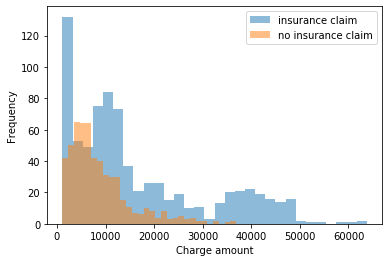

Distributions look a bit exponential, with no insurance looking more exponential than insurance
Insurance could be multimodal. Gamma distribution may be applicable on no insurance distribution, lets test it first.
Developing new method for easiest looking case first is common and sound approach to demonstrate a minimum viable solution/product.


In [3]:
ins = medical.charges[medical.insuranceclaim == 1]
no_ins = medical.charges[medical.insuranceclaim == 0]
ins_count = len(ins)
no_ins_count = len(no_ins)
plt.hist(ins, bins=30, alpha=0.5, label='insurance claim')
plt.hist(no_ins, bins=30, alpha=0.5, label='no insurance claim')
plt.xlabel('Charge amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()
print('Distributions look a bit exponential, with no insurance looking more exponential than insurance')
print('Insurance could be multimodal. Gamma distribution may be applicable on no insurance distribution, lets test it first.')
print('Developing new method for easiest looking case first is common and sound approach to demonstrate a minimum viable solution/product.')

In [4]:
# Initial guess for gamma distributions alpha and beta parameters
alpha_est = np.mean(no_ins) ** 2 / np.var(no_ins)
beta_est = np.var(no_ins) / np.mean(no_ins)
alpha_est, beta_est

(1.8759059725250857, 4702.486170152821)

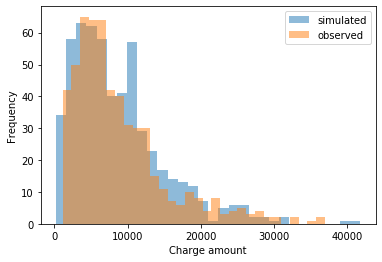

Not bad, but we dont have a best estimate for the population parameters and only have single estimate each for alpha and beta, we are not capturing the uncertainty in their values. Lets take a Bayesian approach.


In [5]:
#Initial simulation
seed(47)
no_ins_model_rvs = gamma(alpha_est, scale=beta_est).rvs(no_ins_count)
plt.hist(no_ins_model_rvs, bins=30, alpha=.5, label='simulated')
plt.hist(no_ins, bins=30, alpha=.5, label='observed')
plt.xlabel('Charge amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()
print('Not bad, but we dont have a best estimate for the population parameters and only have single estimate each for alpha and beta, we are not capturing the uncertainty in their values. Lets take a Bayesian approach.')

In [6]:
#Create a PyMC3 model
#PyMC3 seems to use rate = 1/beta
rate_est = 1 / beta_est
alpha_est, rate_est

(1.8759059725250857, 0.00021265346963636093)

In [7]:
#1 use an exponential prior for alpha. Call the stochastic variable alpha_
# use an exponential prior for the rate parameter in PyMC3's Gamma. Call this stochastic variable rate_
# create a gamma distribution with your alpha_ and rate_ stochastic variables and observed data.
# Perform 10000 draws
with pm.Model() as no_ins_model:
    alpha_ = pm.Exponential("alpha", 1/alpha_est)
    rate_ = pm.Exponential("beta", 1 / rate_est)
    
    no_ins_charge = pm.Gamma("no_ins_charge", alpha=alpha_, beta=rate_, observed=no_ins)
    trace = pm.sample(10000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:32<00:00, 1273.56draws/s]
The acceptance probability does not match the target. It is 0.8944321653119708, but should be close to 0.8. Try to increase the number of tuning steps.


In [8]:
#2 explore your posteriors for alpha and beta 
# 95% credible interval for alpha and beta 
alpha_samps = trace['alpha']
beta_samps = trace['beta']
alpha95 = np.percentile(alpha_samps, [2.5, 97.5])
beta95 = np.percentile(beta_samps, [2.5, 97.5])
alpha95, beta95

(array([1.99128808, 2.48392524]), array([0.00022238, 0.00028488]))

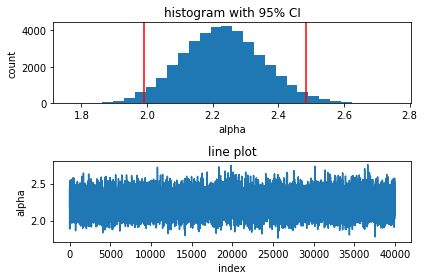

In [9]:
#3 plot your posterior values of alpha and beta (line plots and histograms)
#alpha
plt.subplot(2,1,1)
plt.hist(alpha_samps, bins=30)
plt.axvline(alpha95[0], color='red')
plt.axvline(alpha95[1], color='red')
plt.title('histogram with 95% CI')
plt.xlabel('alpha')
plt.ylabel('count')
plt.subplot(2,1,2)
plt.plot(alpha_samps)
plt.title('line plot')
plt.xlabel('index')
plt.ylabel('alpha')
plt.tight_layout()
plt.show()

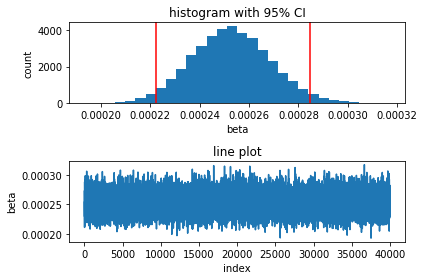

In [10]:
#beta 
plt.subplot(2,1,1)
plt.hist(beta_samps, bins=30)
plt.axvline(beta95[0], color='red')
plt.axvline(beta95[1], color='red')
plt.title('histogram with 95% CI')
plt.xlabel('beta')
plt.ylabel('count')
plt.subplot(2,1,2)
plt.plot(beta_samps)
plt.title('line plot')
plt.xlabel('index')
plt.ylabel('beta')
plt.tight_layout()
plt.show()

C:\Users\Rachid\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Rachid\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027607211448>,
      dtype=object)

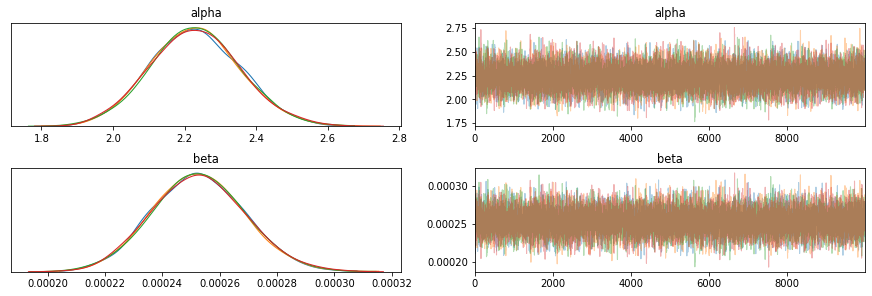

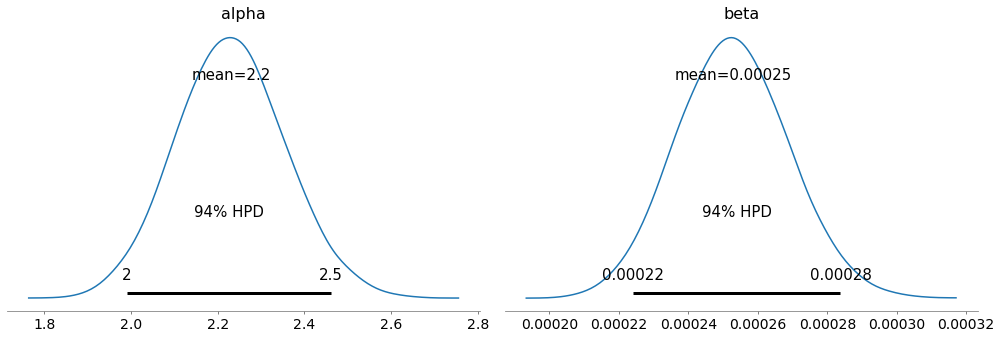

In [13]:
#4 Play around with some of the built-in diagnostic plots for your model.
# Checking out the traceplot alpha and beta
pm.plots.traceplot(trace)
pm.plots.plot_posterior(trace)

2.230942190864106 0.0002528146703168791


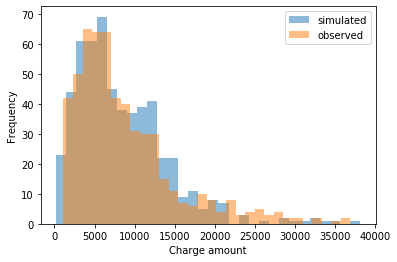

simulated data appears to be an ok fit of the observed data.


In [24]:
#5 Take a shot at a new simulated sequence of medical charges using scipy.stat's gamma distribution
alpha_mean = np.mean(alpha_samps)
beta_mean = np.mean(beta_samps)
print(alpha_mean, beta_mean)
no_ins_model_rvs = gamma(alpha_mean, scale=1/beta_mean).rvs(no_ins_count)
plt.hist(no_ins_model_rvs, bins=30, alpha=.5, label='simulated')
plt.hist(no_ins, bins=30, alpha=.5, label='observed')
plt.xlabel('Charge amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()
print('simulated data appears to be an ok fit of the observed data.')